### Q-Learning for TicTacToe

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm

np.random.seed(42)

In [2]:
class TicTacToe:
    def __init__(self):

        self.observation_space = np.zeros((3, 3))
        self.action_space = np.array([[i, j] for i in range(3) for j in range(3)])

        self.symbols = [1, 2] # player 1 ('X') and player 2 ('O')
        self.starting_player = np.random.choice(self.symbols)  # coin flip to decide starting player
        self.current_player = self.starting_player

    def has_won(self, player):
        for i in range(3):
            if all(self.observation_space[i, :] == player) or all(self.observation_space[:, i] == player):
                return True
        if all(np.diag(self.observation_space) == player) or all(np.diag(np.fliplr(self.observation_space)) == player):
            return True
        return False
    
    def is_draw(self):
        return not 0 in self.observation_space
    
    def move(self, action):
        """Converts the action to a move on the board."""
        return self.action_space[action]
    
    def act(self, action):
        """Move by player.

        Args:
            action (tuple): (i, j) coordinates of the action

        Returns:
            next_observation (np.array): updated observation space
            reward (int): reward for the action
            done (bool): True if the game is over
        """
        action = self.move(action)
        # check if the action is valid
        if self.observation_space[action[0]][action[1]] != 0:
            raise ValueError("Invalid action")
        
        self.observation_space[action[0]][action[1]] = self.current_player
        if self.has_won(self.current_player):
            return self.observation_space, 1, True
        if self.is_draw():
            return self.observation_space, 0, True
        
        self.current_player = 1 if self.current_player == 2 else 2
        return deepcopy(self.observation_space), 0, False

    def print(self):
        """Renders the board, with 'X' and 'O' representing player 1 and 2 respectively"""
        symbols = {0: ' ', 1: 'X', 2: 'O'}
        print("-------------")
        for i in range(3):
            print("|", end=" ")
            for j in range(3):
                print(f"{symbols[self.observation_space[i, j]]}", end=" | ")
            print("\n-------------")

# Check if the environment is working as expected
env = TicTacToe()
env.act(0); env.act(1); env.act(4); env.act(2); 
print(env.act(8))
env.print()

(array([[1., 2., 2.],
       [0., 1., 0.],
       [0., 0., 1.]]), 1, True)
-------------
| X | O | O | 
-------------
|   | X |   | 
-------------
|   |   | X | 
-------------


In [3]:
class Agent:
    def __init__(
        self,
        env,
        initial_learning_rate: float,
        discount_factor: float,
        decay_lr: bool = True,
    ):
        
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(len(self.env.action_space)))

        self.initial_learning_rate = initial_learning_rate
        self.learning_rate = initial_learning_rate
        self.epsilon = 1
        self.episode_count = 1
        self.discount_factor = discount_factor
        self.decay_lr = decay_lr

    def action_to_coordinate(self, action):
        return self.env.action_space[action]

    def find_valid_actions(self, observation):
        """Returns a binary mask of valid actions, of length equal to the number of actions."""
        return np.array([observation[action[0]][action[1]] == 0 for action in self.env.action_space])

    def choose_action(self, observation):
        valid_actions = self.find_valid_actions(observation)
        if np.random.rand() < self.epsilon:
            action = np.random.choice(np.arange(len(self.env.action_space))[valid_actions])
        else:
            max_q = np.max(self.q_values[tuple(observation.flat)][valid_actions])
            action = np.random.choice(np.where((self.q_values[tuple(observation.flat)] == max_q) & valid_actions)[0])
        return action
    
    def choose_greedy_action(self, observation):
        valid_actions = self.find_valid_actions(observation)
        max_q = np.max(self.q_values[tuple(observation.flat)][valid_actions])
        action = np.random.choice(np.where((self.q_values[tuple(observation.flat)] == max_q) & valid_actions)[0])
        return action
    
    def update_q_values(self, observation, action, reward, next_observation):
        td_error = reward + self.discount_factor * np.max(self.q_values[tuple(next_observation.flat)]) - self.q_values[tuple(observation.flat)][action]
        self.q_values[tuple(observation.flat)][action] = self.q_values[tuple(observation.flat)][action] + self.learning_rate * td_error


    def update_lr_eps(self):
        self.episode_count += 1
        if self.decay_lr:
            self.learning_rate = self.initial_learning_rate / self.episode_count
        self.epsilon = 1 / self.episode_count

In [4]:
# Opponents
class RandomAgent:
    def __init__(self, env):
        self.env = env

    def action_to_coordinate(self, action):
        return self.env.action_space[action]

    def find_valid_actions(self, observation):
        """Returns a binary mask of valid actions, of length equal to the number of actions."""
        return np.array([observation[action[0]][action[1]] == 0 for action in self.env.action_space])
    
    def choose_action(self, observation):
        valid_actions = self.find_valid_actions(observation)
        return np.random.choice(np.arange(len(self.env.action_space))[valid_actions])
    

class SafeAgent:
    def __init__(self, env):
        self.env = env

    def action_to_coordinate(self, action):
        return self.env.action_space[action]

    def find_valid_actions(self, observation):
        """Returns a binary mask of valid actions, of length equal to the number of actions."""
        return np.array([observation[action[0]][action[1]] == 0 for action in self.env.action_space])
    
    def has_won(self, player, observation):
        for i in range(3):
            if all(observation[i, :] == player) or all(observation[:, i] == player):
                return True
        if all(np.diag(observation) == player) or all(np.diag(np.fliplr(observation)) == player):
            return True
        return False
    
    def check_if_exists_winning_move(self, observation):
        for a in range(len(self.env.action_space)):
            action = self.action_to_coordinate(a)
            if observation[action[0]][action[1]] == 0:
                observation[action[0]][action[1]] = 2
                if self.has_won(2, observation): 
                    observation[action[0]][action[1]] = 0
                    return a
                observation[action[0]][action[1]] = 0

        return None
    
    def check_if_exists_blocking_move(self, observation):
        for a in range(len(self.env.action_space)):
            action = self.action_to_coordinate(a)
            if observation[action[0]][action[1]] == 0:
                observation[action[0]][action[1]] = 1
                if self.has_won(1, observation):
                    observation[action[0]][action[1]] = 0
                    return a
                observation[action[0]][action[1]] = 0

        return None

    def choose_action(self, observation):
        valid_actions = self.find_valid_actions(observation)
        winning_move = self.check_if_exists_winning_move(observation)  # check if there is a winning move
        if winning_move is not None:
            return winning_move
        blocking_move = self.check_if_exists_blocking_move(observation)  # check if there is a blocking move
        if blocking_move is not None:
            return blocking_move
        return np.random.choice(np.arange(len(self.env.action_space))[valid_actions])

In [5]:
def validate(agent, opponent, num_episodes):
    wins = 0
    draws = 0
    for _ in range(num_episodes):
        env = TicTacToe()
        observation = env.observation_space
        done = False
        while True:
            if env.current_player == 1:
                action = agent.choose_greedy_action(observation)
            else:
                action = opponent.choose_action(observation)

            observation, reward, done = env.act(action)
            if done:
                if reward == 1 and env.current_player == 1:
                    wins += 1
                elif reward == 0:
                    draws += 1
                break

    return wins, draws


def train(agent, num_episodes, validate_freq, initial_opponent=None):
    wins = []
    draws = []
    for episode in tqdm(range(num_episodes)):
        env = TicTacToe()
        observation = deepcopy(env.observation_space)
        done = False

        if initial_opponent is None:
            opponent = RandomAgent(env) if np.random.rand() < 0.5 else SafeAgent(env)
        else:
            opponent = initial_opponent
            
        # the subsequent observations the agent sees must be whenever the agent moves
        if env.current_player == 2:
            action = opponent.choose_action(observation)
            observation, _, _ = env.act(action)

        while True:
            action = agent.choose_action(observation)
            next_observation, reward, done = env.act(action)
            if done:
                if reward == 1:
                    agent.update_q_values(observation, action, 1, next_observation)
                else:
                    agent.update_q_values(observation, action, 0, next_observation)
                break
            next_action = opponent.choose_action(next_observation)
            next_next_observation, next_reward, done = env.act(next_action)
            if done:
                # if opponent wins, the reward is -1
                if next_reward == 1:
                    agent.update_q_values(observation, action, -1, next_next_observation)
                break
            
            agent.update_q_values(observation, action, 0, next_next_observation)

            observation = next_next_observation
        agent.update_lr_eps()

        if episode % validate_freq == 0:
            wins_, draws_ = validate(agent, opponent, 100)
            wins.append(wins_)
            draws.append(draws_)

    return wins, draws

#### Training against random

In [6]:
# hyperparameters
learning_rate = 0.001
n_episodes = 10_000
discount_factor = 1

In [7]:
env = TicTacToe()
agent = Agent(env, learning_rate, discount_factor, decay_lr=False)
rand_opp = RandomAgent(env)

In [8]:
agent.q_values

defaultdict(<function __main__.Agent.__init__.<locals>.<lambda>()>, {})

In [9]:
wins, draws = train(agent, n_episodes, validate_freq=200, initial_opponent=rand_opp)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:02<00:00, 3387.36it/s]


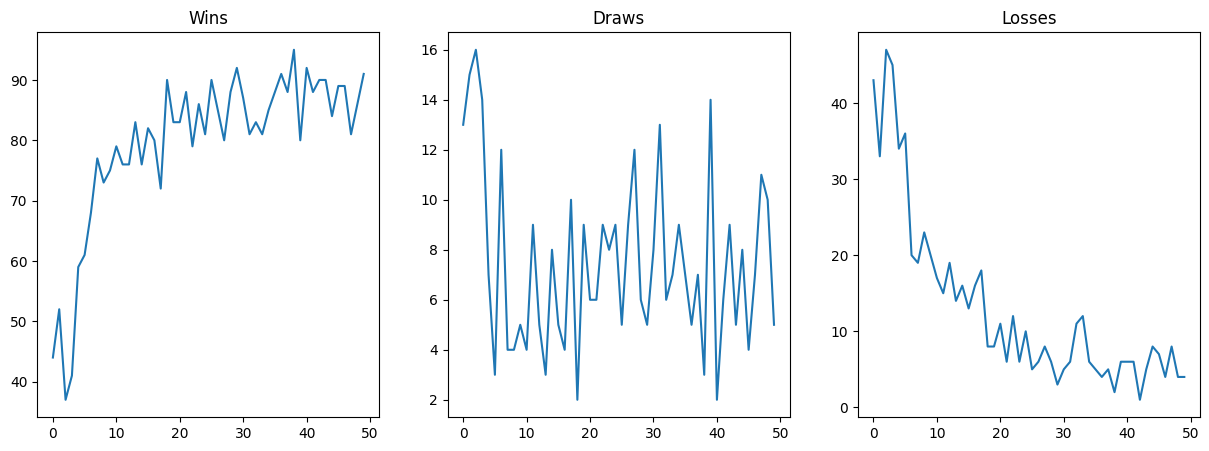

In [10]:
# Plot the win %, loss % and draw % over time
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(wins, label="Wins")
ax[0].set_title("Wins")
ax[1].plot(draws, label="Draws")
ax[1].set_title("Draws")
ax[2].plot(100 - np.array(wins) - np.array(draws), label="Losses")
ax[2].set_title("Losses")
plt.show()

In [11]:
### Test the agent against both random and safe opponents
rand_opp = RandomAgent(env)
safe_opp = SafeAgent(env)

wins_rand, draws_rand = validate(agent, rand_opp, 1000)
wins_safe, draws_safe = validate(agent, safe_opp, 1000)

print(f"Against random opponent: {wins_rand} wins, {draws_rand} draws, {1000 - wins_rand - draws_rand} losses")
print(f"Against safe opponent: {wins_safe} wins, {draws_safe} draws, {1000 - wins_safe - draws_safe} losses")

Against random opponent: 893 wins, 64 draws, 43 losses
Against safe opponent: 99 wins, 437 draws, 464 losses


#### Training against safe

In [12]:
# hyperparameters
learning_rate = 0.001
n_episodes = 10_000
discount_factor = 1

In [13]:
env = TicTacToe()
agent = Agent(env, learning_rate, discount_factor, decay_lr=False)
safe_opp = SafeAgent(env)

In [14]:
wins, draws = train(agent, n_episodes, validate_freq=200, initial_opponent=safe_opp)

100%|██████████| 10000/10000 [00:09<00:00, 1110.05it/s]


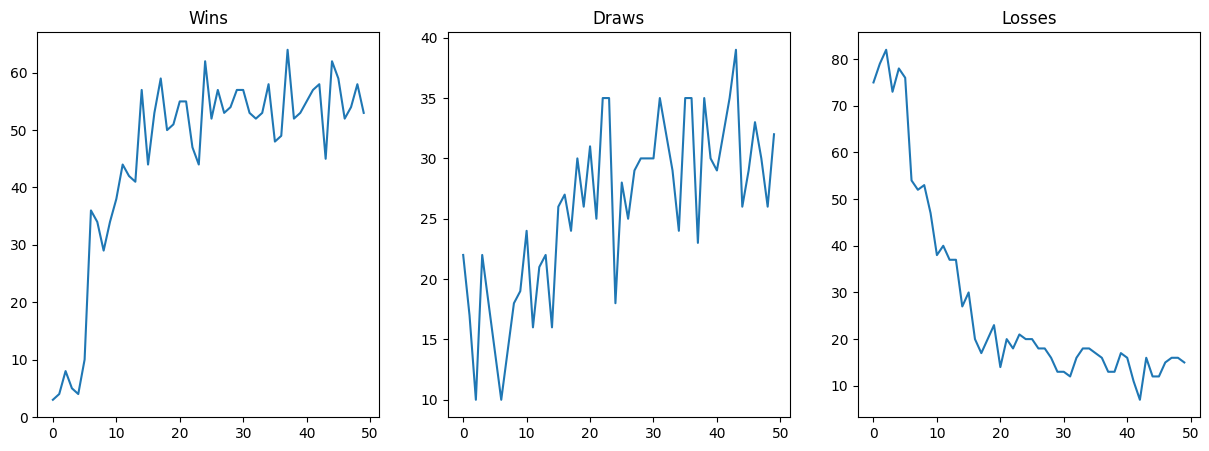

In [15]:
# Plot the win %, loss % and draw % over time
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(wins, label="Wins")
ax[0].set_title("Wins")
ax[1].plot(draws, label="Draws")
ax[1].set_title("Draws")
ax[2].plot(100 - np.array(wins) - np.array(draws), label="Losses")
ax[2].set_title("Losses")
plt.show()

In [16]:
### Test the agent against both random and safe opponents
rand_opp = RandomAgent(env)
safe_opp = SafeAgent(env)

wins_rand, draws_rand = validate(agent, rand_opp, 1000)
wins_safe, draws_safe = validate(agent, safe_opp, 1000)

print(f"Against random opponent: {wins_rand} wins, {draws_rand} draws, {1000 - wins_rand - draws_rand} losses")
print(f"Against safe opponent: {wins_safe} wins, {draws_safe} draws, {1000 - wins_safe - draws_safe} losses")

Against random opponent: 643 wins, 184 draws, 173 losses
Against safe opponent: 556 wins, 297 draws, 147 losses


#### Randomly facing either random or safe

In [17]:
# hyperparameters
learning_rate = 0.001
n_episodes = 10_000
discount_factor = 1

In [18]:
env = TicTacToe()
agent = Agent(env, learning_rate, discount_factor, decay_lr=False)

In [19]:
wins, draws = train(agent, n_episodes, validate_freq=200)

100%|██████████| 10000/10000 [00:06<00:00, 1526.43it/s]


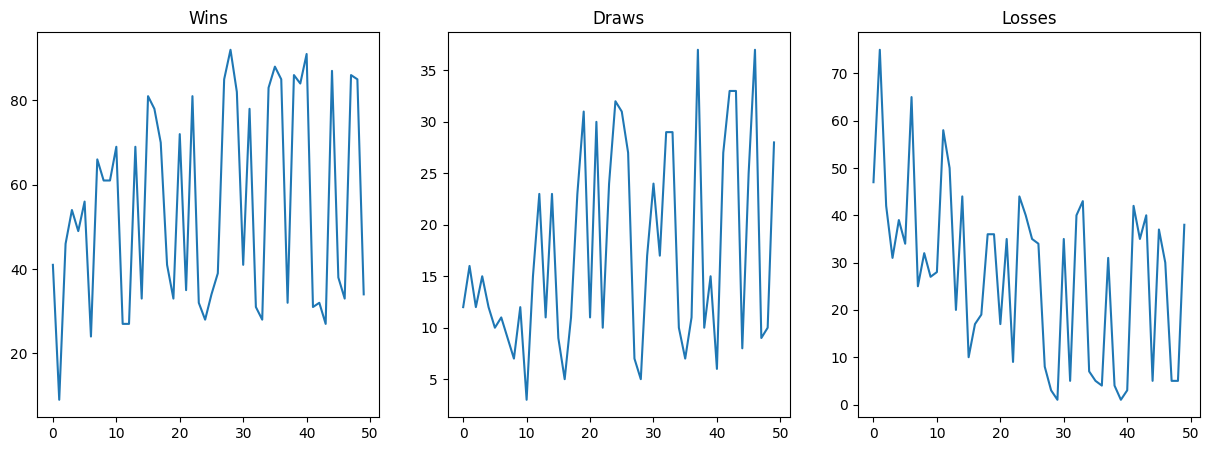

In [20]:
# Plot the win %, loss % and draw % over time
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(wins, label="Wins")
ax[0].set_title("Wins")
ax[1].plot(draws, label="Draws")
ax[1].set_title("Draws")
ax[2].plot(100 - np.array(wins) - np.array(draws), label="Losses")
ax[2].set_title("Losses")
plt.show()

In [21]:
### Test the agent against both random and safe opponents
rand_opp = RandomAgent(env)
safe_opp = SafeAgent(env)

wins_rand, draws_rand = validate(agent, rand_opp, 1000)
wins_safe, draws_safe = validate(agent, safe_opp, 1000)

print(f"Against random opponent: {wins_rand} wins, {draws_rand} draws, {1000 - wins_rand - draws_rand} losses")
print(f"Against safe opponent: {wins_safe} wins, {draws_safe} draws, {1000 - wins_safe - draws_safe} losses")

Against random opponent: 854 wins, 103 draws, 43 losses
Against safe opponent: 349 wins, 262 draws, 389 losses


### Improved Strategy

In [22]:
# Opponents
class RandomAgent:
    def __init__(self, env):
        self.env = env

    def action_to_coordinate(self, action):
        return self.env.action_space[action]

    def find_valid_actions(self, observation):
        """Returns a binary mask of valid actions, of length equal to the number of actions."""
        return np.array([observation[action[0]][action[1]] == 0 for action in self.env.action_space])
    
    def choose_action(self, observation):
        valid_actions = self.find_valid_actions(observation)
        return np.random.choice(np.arange(len(self.env.action_space))[valid_actions])
    

class RandSafeAgent:
    def __init__(self, env, p=0.02):
        self.env = env
        self.p = p

    def action_to_coordinate(self, action):
        return self.env.action_space[action]

    def find_valid_actions(self, observation):
        """Returns a binary mask of valid actions, of length equal to the number of actions."""
        return np.array([observation[action[0]][action[1]] == 0 for action in self.env.action_space])
    
    def has_won(self, player, observation):
        for i in range(3):
            if all(observation[i, :] == player) or all(observation[:, i] == player):
                return True
        if all(np.diag(observation) == player) or all(np.diag(np.fliplr(observation)) == player):
            return True
        return False
    
    def check_if_exists_winning_move(self, observation):
        for a in range(len(self.env.action_space)):
            action = self.action_to_coordinate(a)
            if observation[action[0]][action[1]] == 0:
                observation[action[0]][action[1]] = 2
                if self.has_won(2, observation): 
                    observation[action[0]][action[1]] = 0
                    return a
                observation[action[0]][action[1]] = 0

        return None
    
    def check_if_exists_blocking_move(self, observation):
        for a in range(len(self.env.action_space)):
            action = self.action_to_coordinate(a)
            if observation[action[0]][action[1]] == 0:
                observation[action[0]][action[1]] = 1
                if self.has_won(1, observation):
                    observation[action[0]][action[1]] = 0
                    return a
                observation[action[0]][action[1]] = 0

        return None

    def choose_action(self, observation):
        valid_actions = self.find_valid_actions(observation)
        winning_move = self.check_if_exists_winning_move(observation)  # check if there is a winning move
        choose_smart_move = np.random.rand() > self.p  # forgets to look for a smart move with probability p
        if choose_smart_move:
            if winning_move is not None:
                return winning_move
            blocking_move = self.check_if_exists_blocking_move(observation)  # check if there is a blocking move
            if blocking_move is not None:
                return blocking_move
        return np.random.choice(np.arange(len(self.env.action_space))[valid_actions])

In [23]:
# hyperparameters
learning_rate = 0.001
n_episodes = 10_000
discount_factor = 1

In [24]:
env = TicTacToe()
agent = Agent(env, learning_rate, discount_factor, decay_lr=False)
rand_safe_opp = RandSafeAgent(env, p=0.2)

In [25]:
wins, draws = train(agent, n_episodes, validate_freq=200, initial_opponent=rand_safe_opp)

100%|██████████| 10000/10000 [00:08<00:00, 1170.86it/s]


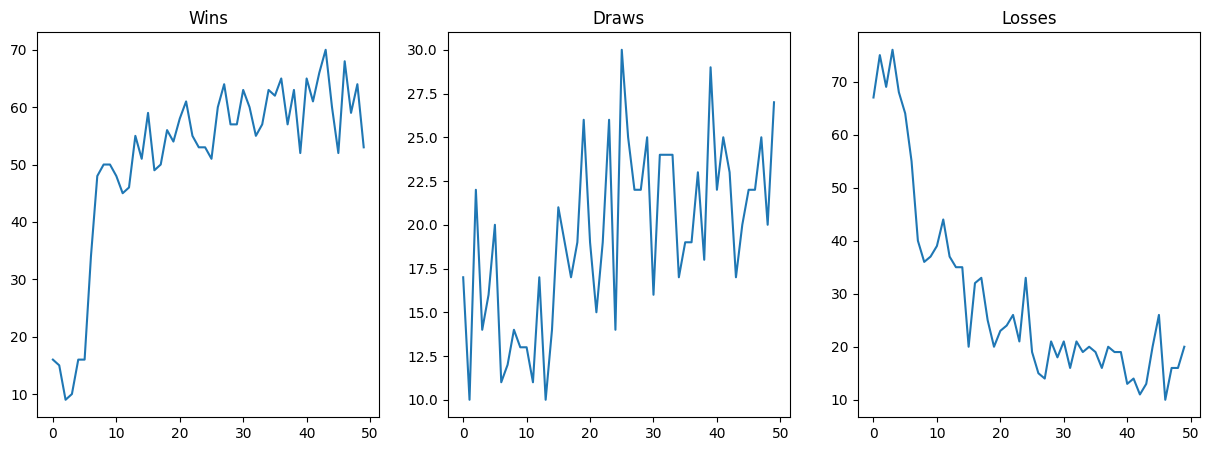

In [26]:
# Plot the win %, loss % and draw % over time
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(wins, label="Wins")
ax[0].set_title("Wins")
ax[1].plot(draws, label="Draws")
ax[1].set_title("Draws")
ax[2].plot(100 - np.array(wins) - np.array(draws), label="Losses")
ax[2].set_title("Losses")
plt.show()

In [27]:
### Test the agent against both random and safe opponents
rand_opp = RandomAgent(env)
safe_opp = SafeAgent(env)

wins_rand, draws_rand = validate(agent, rand_opp, 1000)
wins_safe, draws_safe = validate(agent, safe_opp, 1000)

print(f"Against random opponent: {wins_rand} wins, {draws_rand} draws, {1000 - wins_rand - draws_rand} losses")
print(f"Against safe opponent: {wins_safe} wins, {draws_safe} draws, {1000 - wins_safe - draws_safe} losses")

Against random opponent: 838 wins, 101 draws, 61 losses
Against safe opponent: 523 wins, 289 draws, 188 losses


**(4) Among the three agents developed, which agent is best? Why?**

The 3 agents all have their individual strengths. The agent trained against the random opponent does best against the random opponent, while the agent trained against the safe opponent does best against the safe opponent. The agent trained against both the opponents is in between, and is arguably the best because it is the most balanced; it doesn't lose to the safe opponent as much as the agent trained against the random opponent, and is better against the random opponent than the agent trained against the safe opponent. The versatility of the third agent comes from the expanded (explored) state space; the other two agents have overfit to their respective opponents.

**(5) Is the Q-learning agent developed unbeatable against any possible opponent ? If not,
suggest ways to improve the training process.**

The trained agents are clearly not unbeatable, and exhibit weaknesses. There are several promising directions to improve the training process:
- The 4th technique explored above is an impovement over the safe agent: the opponent is strong, but there is some randomness, so more of the state space is explored. The training is also more stable.
- A stronger opponent can be used (for instance, a minimax agent). The agent will learn to play optimally against this opponent, and will be stronger against weaker opponents as well. Some randomization can be added to the minimax agent, to prevent "overfitting" to the minimax agent's strategy.